# Взвешенное голосование методов
- ближайшего соседа, 
- градиентного бустинга с логистической функцией потерь (базовый алгоритм CART),
- логистической регресcии

### Для задач классификации следует использовать тестовые датасеты:
  - https://archive.ics.uci.edu/ml/datasets/Wine
  - https://archive.ics.uci.edu/ml/datasets/Iris
  - https://archive.ics.uci.edu/ml/datasets/Liver+Disorders

## О правилах сдачи данного ДЗ:
#### Ваше решение должно быть не более чем на 3% хуже, чем решение из scikitlearn-a в относительных числах при одинаковых параметрах запуска для спамовского датасета. В момент проверки дз первое, что вы показываете это графики ошибки на обучении и на тесте для вашего алгоритма и библиотечного. Также на графике должна быть обозначена относительная 3-х процентная граница. Пока данный результат не достигнут баллы за данное дз получить невозможно.

### Логистическая функция потерь

$$L(h)= \sum\limits_{i=1}^{N}(−y_i log(f(\textbf{x}_i))−(1−y_i)log(1−f(\textbf{x}_i)))$$


$$f (\textbf{x}_i ) = \sigma(h(\textbf{x}_i )) = \frac{1}{1+\exp^{−h(x_i)}}$$

In [1]:
from sklearn.ensemble import GradientBoostingClassifier

In [2]:
from sklearn.tree import DecisionTreeRegressor

In [3]:
import numpy as np

In [4]:
import pandas as pd

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
from joblib import Parallel, delayed

In [7]:
from sklearn.tree import export_graphviz

In [8]:
from sklearn.preprocessing import LabelBinarizer

In [9]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

## Data

In [10]:
cache_vocs = {}

In [11]:
def translate_to_int(df, column):
    if column in df.columns:
        if not cache_vocs.has_key(column):
            unique = df[column].unique()
            cache_vocs[column] = dict()
            cache_vocs[column+'_I'] = dict()
            for i, label in enumerate(unique):
                cache_vocs[column][label] = i
                cache_vocs[column+'_I'][i] = [label]
        df[column] = map(lambda x: cache_vocs[column][x], df[column])

In [12]:
def load_data(path, columns, to_int = [], sep=','):
    data = pd.read_csv(path, sep=sep, header=None)
    data.columns = columns
    for col_name in to_int:
        translate_to_int(data, col_name)
    return data.dropna()

In [13]:
def load_splitted(data, k = 0, test_size = 0.33, random_state = None):
    data_X, data_y = data[data.columns[:k].tolist()+data.columns[k+1:].tolist()].as_matrix(), data[data.columns[k]].as_matrix()
    data_y -= data_y.min()
    return train_test_split(data_X, data_y, test_size=test_size, random_state=random_state)

### SPAM

In [14]:
spamTrainDataPath = './data/spam/spam.train.txt'
spamTestDataPath = './data/spam/spam.test.txt'
spamColumns = ['ClassProb'] + map(str, range(102))

In [15]:
def loadSpam(random_state = None):
    dataTrain = load_data(spamTrainDataPath, spamColumns, sep='\s+')
    dataTrain = dataTrain[spamColumns[1:]+spamColumns[:1]]
    dataTest = load_data(spamTestDataPath, spamColumns, sep='\s+')
    dataTest = dataTest[spamColumns[1:]+spamColumns[:1]]
    train_X, train_y = dataTrain[dataTrain.columns[:-1]].as_matrix(), dataTrain[dataTrain.columns[-1]].as_matrix()
    test_X, test_y = dataTest[dataTest.columns[:-1]].as_matrix(), dataTest[dataTest.columns[-1]].as_matrix()
    return train_X, test_X, train_y, test_y

### Wine

In [16]:
wineDataPath = './data/wine.data.txt'
wineColumns = ['CLASS', 'ALC', 'M_ACID', 'ASH', 'AL_ASH', 'MAG', 'TOT', 'FLAV', 'NON_PH',
               'PROANT', 'COL_INT', 'HUE', 'OD', 'PROLINE']

In [17]:
def loadWine(random_state = None):
    return load_splitted(load_data(wineDataPath, wineColumns), random_state=random_state)

### Iris

In [18]:
irisDataPath = './data/iris.data.txt'
irisColumns = ['SEP_LEN', 'SEP_WID', 'PET_LEN', 'PER_WID', 'CLASS']

In [19]:
def loadIris(random_state = None):
    return load_splitted(load_data(irisDataPath, irisColumns, ['CLASS']), k=4, random_state=random_state)

### Bupa

In [20]:
bupaDataPath = './data/bupa.data.txt'
bupaColumns = ['MCV', 'ALKPHOS', 'SGPT', 'SGOT', 'GAMMAGT', 'DRINKS', 'CLASS']

In [21]:
def loadBupa(random_state = None):
    return load_splitted(load_data(bupaDataPath, bupaColumns), k=6, random_state=random_state)

## Code

In [22]:
def bestSplit(X, y, Sr, j, srt):
    Xv = X[srt]
    yv = y[srt]
    BestTillNow = 0
    BestCutPoint = Xv[0]
    Sl = 0
    n = len(yv)
    for i in xrange(0, len(Xv)-1):
        Sl += yv[i]
        Sr -= yv[i]
        if (Xv[i+1]>Xv[i]):
            NewSplitValue = (Sl**2)/(i+1.)+(Sr**2)/(n-i-1.)
            if NewSplitValue > BestTillNow:
                BestTillNow = NewSplitValue
                BestCutPoint = Xv[i:i+2].mean()
    return (BestTillNow, BestCutPoint, j)

In [23]:
class DTR:
    def __init__(self, max_depth=3, random_state=None, depth=0, min_samples = 1):
        self.max_depth = max_depth
        self.random_state = random_state
        self.depth = depth
        self.min_samples = min_samples
        self.final = True
        self.left  = None
        self.right = None
        
    def info(self):
        return zip(self.n_features(), self.borders(), self.errors(), self.n_node_samples(), self.values())
    
    def n_features(self):
        if self.final:
            return [('J: ', None)]
        return [('J: ', self.j)] + self.left.n_features() + self.right.n_features()
    
    def errors(self):
        if self.final:
            return [('MSE: ', self.inf)]
        return [('MSE: ', self.inf)] + self.left.errors() + self.right.errors()
    
    def borders(self):
        if self.final:
            return [('SPLIT: ', None)]
        return [('SPLIT: ', self.t)] + self.left.borders() + self.right.borders()
        
    def values(self):
        if self.final:
            return [('VALUE: ', self.value)]
        return [('VALUE: ', self.value)] + self.left.values() + self.right.values()
    
    def n_node_samples(self):
        if self.final:
            return [('SAMPLES: ', self.n_samples)]
        return [('SAMPLES: ', self.n_samples)] + self.left.n_node_samples() + self.right.n_node_samples()
        
    def split(self, Xm, j, t):
        mask = (Xm[:,j] <= t).reshape(-1, 1)
        Il = np.where(mask)[0]
        Ir = np.where(~mask)[0]
        return Il, Ir
    
    def predict(self, X):
        if len(X.shape) == 1: X = np.array([X])
        y = np.zeros((X.shape[0],1))
        if self.final:
            y.fill(self.value)
        else:
            Il, Ir = self.split(X, self.j, self.t)
            y[Il] = self.left.predict(X[Il])
            y[Ir] = self.right.predict(X[Ir])
        return y
    
    def update_leafs(self, X, y, residual, K = 2):
        if self.final:
            numerator = np.sum(residual)
            denominator = np.sum((y - residual) * (1. - y + residual))
            if denominator < 1e-100:
                self.value = 0.0
            else:
                self.value = numerator / denominator
        else:
            Il, Ir = self.split(X, self.j, self.t)
            self.left.update_leafs(X[Il], y[Il], residual[Il])
            self.right.update_leafs(X[Ir], y[Ir], residual[Ir])
    
    def __build_tree(self, X, y, srt_mask = None):
        if y.shape[0] == 0:
            self.final = True
            self.value = None
            self.inf = None
            self.n_samples = None
            return
        
        self.final = False
        self.value = np.mean(y)
        self.inf = mean_squared_error(y, [self.value]*y.shape[0])
        self.n_samples = y.shape[0]
            
        if (self.depth == self.max_depth) or (y.shape[0] <= self.min_samples) or (self.inf < 1e-7):
            self.final = True
            return
            
        Sr = y.sum()
        if srt_mask is None:
            srt_mask = X.argsort(axis=0)
        Qerrors = Parallel(n_jobs=4)(delayed(bestSplit)(X[:,j], y, Sr, j, srt_mask[:,j]) for j in xrange(X.shape[1]))
        _, self.t, self.j = max(Qerrors)
        Il, Ir = self.split(X, self.j, self.t)
        
        self.left  = DTR(max_depth=self.max_depth,
                         random_state=self.random_state,
                         depth = self.depth+1,
                         min_samples = self.min_samples)
        self.left.__build_tree(X[Il], y[Il])

        self.right = DTR(max_depth=self.max_depth,
                         random_state=self.random_state,
                         depth = self.depth+1,
                         min_samples = self.min_samples)
        self.right.__build_tree(X[Ir], y[Ir])
    
    def fit(self, X, y, srt_mask = None):
        self.__build_tree(X, y, srt_mask)

# Compare with sklearn CART

In [24]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

In [25]:
X_train, X_test, y_train, y_test = loadIris(10)

In [26]:
tree_1 = DTR(max_depth=3, random_state=42)
tree_1.fit(X_train, y_train)

In [27]:
tree_2 = DecisionTreeRegressor(criterion='mse', max_depth=3, random_state=42)
tree_2.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=42,
           splitter='best')

In [28]:
export_graphviz(tree_2, './data/trees/tree.dot')
!dot -Tpng './data/trees/tree.dot' -o './data/trees/tree.png'

<img src="./data/tree.png">

In [29]:
tree_1.info()

[(('J: ', 2),
  ('SPLIT: ', 2.4500000000000002),
  ('MSE: ', 0.68989999999999996),
  ('SAMPLES: ', 100),
  ('VALUE: ', 0.98999999999999999)),
 (('J: ', None),
  ('SPLIT: ', None),
  ('MSE: ', 0.0),
  ('SAMPLES: ', 35),
  ('VALUE: ', 0.0)),
 (('J: ', 2),
  ('SPLIT: ', 4.75),
  ('MSE: ', 0.24946745562130182),
  ('SAMPLES: ', 65),
  ('VALUE: ', 1.523076923076923)),
 (('J: ', 3),
  ('SPLIT: ', 1.6000000000000001),
  ('MSE: ', 0.032222222222222201),
  ('SAMPLES: ', 30),
  ('VALUE: ', 1.0333333333333334)),
 (('J: ', None),
  ('SPLIT: ', None),
  ('MSE: ', 0.0),
  ('SAMPLES: ', 29),
  ('VALUE: ', 1.0)),
 (('J: ', None),
  ('SPLIT: ', None),
  ('MSE: ', 0.0),
  ('SAMPLES: ', 1),
  ('VALUE: ', 2.0)),
 (('J: ', 3),
  ('SPLIT: ', 1.75),
  ('MSE: ', 0.053877551020408178),
  ('SAMPLES: ', 35),
  ('VALUE: ', 1.9428571428571428)),
 (('J: ', None),
  ('SPLIT: ', None),
  ('MSE: ', 0.23999999999999999),
  ('SAMPLES: ', 5),
  ('VALUE: ', 1.6000000000000001)),
 (('J: ', None),
  ('SPLIT: ', None),
  ('MS

In [30]:
(tree_1.predict(X_test).ravel() == tree_2.predict(X_test).ravel()).all()

True

## CARTs are equal

# Gradient Boosting

In [31]:
from sklearn.metrics import accuracy_score

In [32]:
from sklearn.ensemble import GradientBoostingClassifier as GBC

In [33]:
from sklearn.ensemble.gradient_boosting import MultinomialDeviance, BinomialDeviance

In [78]:
X_train, X_test, y_train, y_test = loadSpam(10)

In [35]:
class LogOddsEstimator:
    scale = 1.0
    def fit(self, X, y):
        pos = np.sum(y)
        neg = y.shape[0] - pos
        if neg == 0 or pos == 0:
            raise ValueError('y contains non binary labels.')
        self.prior = self.scale * np.log(pos / float(neg))

    def predict(self, X):
        y = np.empty((X.shape[0], 1), dtype=np.float64)
        y.fill(self.prior)
        return y

In [42]:
class LogisticLoss:
    def __call__(self, y, y_pred):
        y_pred_sigm = self._score_to_proba(y_pred.ravel())
        score = 2 * np.mean(-y*np.log(y_pred_sigm)-(1-y)*np.log(1-y_pred_sigm))
        return score
    
    def negative_gradient(self, y, y_pred, k = None):
        return (y - self._score_to_proba(y_pred.ravel()))
    
    def _score_to_proba(self, x):
        return 1./(1. + np.exp(-x))
    
    def init_estimator(self):
        return LogOddsEstimator()

In [43]:
class PriorProbabilityEstimator:
    def fit(self, X, y, sample_weight = None):
        class_counts = np.bincount(y)
        self.priors = class_counts / float(class_counts.sum())

    def predict(self, X):
        y = np.empty((X.shape[0], self.priors.shape[0]), dtype=np.float64)
        y[:] = self.priors
        return y

In [44]:
class MultiLogisticLoss:
    def __init__(self, k):
        self.n_classes = k
        
    def __call__(self, y, y_pred):
        y_pred_softmax = self._score_to_proba(y_pred)
        score = 0
        Y = np.zeros((y.shape[0], self.n_classes), dtype=np.float64)
        for k in xrange(self.n_classes):
            Y[:, k] = y == k
        score = -np.sum(Y*np.log(y_pred_softmax))
        return score
    
    def negative_gradient(self, y_bin, y_pred, k):
        return (y_bin - self._score_to_proba(y_pred)[:,k])
    
    def _score_to_proba(self, x):
        exp = np.exp(x)
        return exp/exp.sum(keepdims=True, axis=1)
    
    def init_estimator(self):
        return PriorProbabilityEstimator()

In [106]:
class GradientBoostingClassifier:
    def __init__(self, max_depth = 3, n_estimators=5, random_state=None, learning_rate = 0.1, verbose = False):
        self.max_depth = max_depth
        self.n_estimators = n_estimators
        self.random_state = random_state
        self.learning_rate = learning_rate
        self.verbose = verbose
        
    def fit(self, X, y, X_test = None, y_test = None):
        self.train_losses = []
        self.test_losses = []
        X = X.astype(np.float32)
        self.n_classes = len(np.unique(y))
        if self.n_classes < 3:
            self.loss = LogisticLoss()
            self.estimators = np.empty((self.n_estimators, 1), dtype=np.object)
        else:
            self.loss = MultiLogisticLoss(self.n_classes)
            self.estimators = np.empty((self.n_estimators, self.n_classes), dtype=np.object)
        self.init = self.loss.init_estimator()
        self.init_estimator(X, y)
        self.__fit_stages(X, y, X_test, y_test, self.random_state)
    
    def init_estimator(self, X, y):
        self.init.fit(X, y)
    
    def __fit_stages(self, X, y, X_test, y_test, random_state):
        y_pred = self.init_predict(X)
        srt_mask = X.argsort(axis=0)
        for est in xrange(self.estimators.shape[0]):
            y_pred = self.__fit_stage(est, X, y, y_pred, random_state, srt_mask)
            self.train_losses.append(self.loss(y, y_pred))
            if not ((X_test is None) or (y_test is None)):
                self.test_losses.append(self.loss(y_test, self.decision_function(X_test, est+1)))
            if self.verbose:
                print 'Step:\t{}, '.format(est) +\
                'Train Loss: {:.6f}, '.format(self.train_losses[-1]) +\
                'Train Acc: {:.6f}, '.format(accuracy_score(y, self.predict(X, est + 1))) +\
                '{}'.format('Test Loss: {:.6f}, Test Acc: {:.6f}'.format(self.test_losses[-1],
                                                                         accuracy_score(y_test,
                            self.predict(X_test, est + 1))) if not ((X_test is None) or (y_test is None)) else '')
            
    def __fit_stage(self, est, X, y, y_pred, random_state, srt_mask):
        for i in xrange(self.estimators.shape[1]):
            if self.n_classes < 3:
                y_bin = y
            else:
                y_bin = y == i
            residual = self.loss.negative_gradient(y_bin, y_pred, i)
            tree = DTR(self.max_depth, random_state)
            tree.fit(X, residual, srt_mask)
            tree.update_leafs(X, y_bin, residual)
            self.estimators[est, i] = tree
        return self.decision_function(X, est+1)
    
    def predict(self, X, n_estimators = None):
        if self.n_classes < 3:
            return np.array(self.predict_proba(X, n_estimators)>0.5, dtype=np.int32)
        else:
            return np.argmax(self.predict_proba(X, n_estimators), axis=1)
    
    def predict_proba(self, X, n_estimators = None):
        decision = self.decision_function(X, n_estimators)
        return self.loss._score_to_proba(decision)
        
    def init_predict(self, X):
        return self.init.predict(X)
    
    def decision_function(self, X, n_estimators = None):
        score = self.init.predict(X).astype(np.float64)
        if n_estimators is None:
            n_estimators = self.n_estimators
        for est in xrange(n_estimators):
            est_pred = np.array([self.estimators[est, i].predict(X).ravel() for i in xrange(self.estimators.shape[1])]).T
            score += self.learning_rate * est_pred
        return score

# Spam

In [98]:
X_train, X_test, y_train, y_test = loadSpam(10)

### Realized Train 10

In [41]:
model = GradientBoostingClassifier(max_depth=3, n_estimators=10, learning_rate=0.1, random_state=41, verbose=True)

In [42]:
model.fit(X_train, y_train, X_test, y_test)

Step:	0, Train Loss: 1.243280, Train Acc: 0.581277, Test Loss: 1.148639, Test Acc: 0.797832
Step:	1, Train Loss: 1.146717, Train Acc: 0.795855, Test Loss: 1.098200, Test Acc: 0.899861
Step:	2, Train Loss: 1.066547, Train Acc: 0.864091, Test Loss: 1.040699, Test Acc: 0.906225
Step:	3, Train Loss: 0.997443, Train Acc: 0.869590, Test Loss: 0.998278, Test Acc: 0.906325
Step:	4, Train Loss: 0.931978, Train Acc: 0.896659, Test Loss: 0.972839, Test Acc: 0.887828
Step:	5, Train Loss: 0.876972, Train Acc: 0.893134, Test Loss: 0.923649, Test Acc: 0.912788
Step:	6, Train Loss: 0.827917, Train Acc: 0.906528, Test Loss: 0.869986, Test Acc: 0.912689
Step:	7, Train Loss: 0.781046, Train Acc: 0.911603, Test Loss: 0.861992, Test Acc: 0.905430
Step:	8, Train Loss: 0.743543, Train Acc: 0.915833, Test Loss: 0.834274, Test Acc: 0.915473
Step:	9, Train Loss: 0.706295, Train Acc: 0.923587, Test Loss: 0.823929, Test Acc: 0.908711


In [43]:
accuracy_score(y_test, model.predict(X_test))

0.9087112171837709

### Sklearn Train 10 

In [44]:
model_sk = GBC(n_estimators=10, max_depth=3, verbose=1, criterion='mse', loss='deviance',
               random_state=41)

In [45]:
model_sk.fit(X_train, y_train)

      Iter       Train Loss   Remaining Time 
         1           1.2433            0.50s
         2           1.1467            0.41s
         3           1.0665            0.33s
         4           0.9974            0.27s
         5           0.9320            0.23s
         6           0.8770            0.18s
         7           0.8279            0.14s
         8           0.7810            0.09s
         9           0.7435            0.04s
        10           0.7063            0.00s


GradientBoostingClassifier(criterion='mse', init=None, learning_rate=0.1,
              loss='deviance', max_depth=3, max_features=None,
              max_leaf_nodes=None, min_impurity_split=1e-07,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=10,
              presort='auto', random_state=41, subsample=1.0, verbose=1,
              warm_start=False)

In [46]:
accuracy_score(y_test, model_sk.predict(X_test))

0.90851233094669848

# Bupa

In [117]:
X_train, X_test, y_train, y_test = loadBupa(10)

### Realized Train 10

In [118]:
model = GradientBoostingClassifier(max_depth=3, n_estimators=10, learning_rate=0.1, random_state=41, verbose=True)

In [119]:
model.fit(X_train, y_train, X_test, y_test)

Step:	0, Train Loss: 1.252751, Train Acc: 0.636364, Test Loss: 1.471427, Test Acc: 0.464912
Step:	1, Train Loss: 1.206708, Train Acc: 0.636364, Test Loss: 1.450069, Test Acc: 0.464912
Step:	2, Train Loss: 1.160693, Train Acc: 0.718615, Test Loss: 1.432747, Test Acc: 0.526316
Step:	3, Train Loss: 1.120125, Train Acc: 0.731602, Test Loss: 1.405815, Test Acc: 0.517544
Step:	4, Train Loss: 1.093573, Train Acc: 0.770563, Test Loss: 1.392037, Test Acc: 0.543860
Step:	5, Train Loss: 1.073127, Train Acc: 0.779221, Test Loss: 1.383290, Test Acc: 0.552632
Step:	6, Train Loss: 1.043766, Train Acc: 0.792208, Test Loss: 1.376610, Test Acc: 0.570175
Step:	7, Train Loss: 1.027613, Train Acc: 0.792208, Test Loss: 1.370104, Test Acc: 0.578947
Step:	8, Train Loss: 1.005764, Train Acc: 0.800866, Test Loss: 1.364675, Test Acc: 0.596491
Step:	9, Train Loss: 0.976416, Train Acc: 0.813853, Test Loss: 1.347293, Test Acc: 0.578947


In [120]:
accuracy_score(y_test, model.predict(X_test))

0.57894736842105265

### Sklearn Train 10 

In [121]:
model_sk = GBC(n_estimators=10, max_depth=3, verbose=1, criterion='mse', loss='deviance',
               random_state=41)

In [122]:
model_sk.fit(X_train, y_train)

      Iter       Train Loss   Remaining Time 
         1           1.2528            0.01s
         2           1.2067            0.01s
         3           1.1607            0.01s
         4           1.1201            0.01s
         5           1.0935            0.00s
         6           1.0733            0.00s
         7           1.0439            0.00s
         8           1.0281            0.00s
         9           1.0061            0.00s
        10           0.9765            0.00s


GradientBoostingClassifier(criterion='mse', init=None, learning_rate=0.1,
              loss='deviance', max_depth=3, max_features=None,
              max_leaf_nodes=None, min_impurity_split=1e-07,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=10,
              presort='auto', random_state=41, subsample=1.0, verbose=1,
              warm_start=False)

In [123]:
accuracy_score(y_test, model_sk.predict(X_test))

0.57894736842105265

# Wine

In [107]:
X_train, X_test, y_train, y_test = loadWine(10)

### Realized Train 10

In [108]:
model = GradientBoostingClassifier(max_depth=3, n_estimators=10, learning_rate=0.1, random_state=41, verbose=True)

In [109]:
model.fit(X_train, y_train, X_test, y_test)

Step:	0, Train Loss: 97.584554, Train Acc: 1.000000, Test Loss: 51.925500, Test Acc: 0.830508
Step:	1, Train Loss: 75.191578, Train Acc: 1.000000, Test Loss: 43.455278, Test Acc: 0.830508
Step:	2, Train Loss: 58.912583, Train Acc: 1.000000, Test Loss: 37.377028, Test Acc: 0.830508
Step:	3, Train Loss: 46.662814, Train Acc: 1.000000, Test Loss: 32.865998, Test Acc: 0.830508
Step:	4, Train Loss: 37.242336, Train Acc: 1.000000, Test Loss: 29.450578, Test Acc: 0.830508
Step:	5, Train Loss: 29.889291, Train Acc: 1.000000, Test Loss: 26.833016, Test Acc: 0.830508
Step:	6, Train Loss: 24.088425, Train Acc: 1.000000, Test Loss: 24.812889, Test Acc: 0.830508
Step:	7, Train Loss: 19.475700, Train Acc: 1.000000, Test Loss: 23.249134, Test Acc: 0.830508
Step:	8, Train Loss: 15.785611, Train Acc: 1.000000, Test Loss: 22.039195, Test Acc: 0.830508
Step:	9, Train Loss: 12.819841, Train Acc: 1.000000, Test Loss: 21.106664, Test Acc: 0.830508


In [110]:
accuracy_score(y_test, model.predict(X_test))

0.83050847457627119

### Sklearn Train 10 

In [111]:
model_sk = GBC(n_estimators=10, max_depth=3, verbose=1, criterion='mse', loss='deviance',
               random_state=41)

In [112]:
model_sk.fit(X_train, y_train)

      Iter       Train Loss   Remaining Time 
         1         108.4048            0.13s
         2          91.1632            0.07s
         3          77.2745            0.04s
         4          65.8847            0.03s
         5          56.4246            0.02s
         6          48.4927            0.02s
         7          41.7935            0.01s
         8          36.1028            0.01s
         9          31.2464            0.00s
        10          27.0862            0.00s


GradientBoostingClassifier(criterion='mse', init=None, learning_rate=0.1,
              loss='deviance', max_depth=3, max_features=None,
              max_leaf_nodes=None, min_impurity_split=1e-07,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=10,
              presort='auto', random_state=41, subsample=1.0, verbose=1,
              warm_start=False)

In [113]:
accuracy_score(y_test, model_sk.predict(X_test))

0.81355932203389836

# Iris

In [124]:
X_train, X_test, y_train, y_test = loadIris(10)

### Realized Train 10

In [125]:
model = GradientBoostingClassifier(max_depth=3, n_estimators=10, learning_rate=0.1, random_state=41, verbose=True)

In [126]:
model.fit(X_train, y_train, X_test, y_test)

Step:	0, Train Loss: 82.733894, Train Acc: 1.000000, Test Loss: 43.108808, Test Acc: 0.900000
Step:	1, Train Loss: 64.202282, Train Acc: 1.000000, Test Loss: 35.012988, Test Acc: 0.900000
Step:	2, Train Loss: 50.686260, Train Acc: 1.000000, Test Loss: 29.447266, Test Acc: 0.900000
Step:	3, Train Loss: 40.455599, Train Acc: 1.000000, Test Loss: 25.196021, Test Acc: 0.900000
Step:	4, Train Loss: 32.537812, Train Acc: 1.000000, Test Loss: 22.215852, Test Acc: 0.900000
Step:	5, Train Loss: 26.337811, Train Acc: 1.000000, Test Loss: 19.837703, Test Acc: 0.900000
Step:	6, Train Loss: 21.410614, Train Acc: 1.000000, Test Loss: 17.939225, Test Acc: 0.900000
Step:	7, Train Loss: 17.483146, Train Acc: 1.000000, Test Loss: 16.644165, Test Acc: 0.900000
Step:	8, Train Loss: 14.322389, Train Acc: 1.000000, Test Loss: 15.598637, Test Acc: 0.900000
Step:	9, Train Loss: 11.754086, Train Acc: 1.000000, Test Loss: 15.085050, Test Acc: 0.900000


In [127]:
accuracy_score(y_test, model.predict(X_test))

0.90000000000000002

### Sklearn Train 10 

In [128]:
model_sk = GBC(n_estimators=10, max_depth=3, verbose=1, criterion='mse', loss='deviance',
               random_state=41)

In [129]:
model_sk.fit(X_train, y_train)

      Iter       Train Loss   Remaining Time 
         1          91.6490            0.03s
         2          77.4005            0.02s
         3          65.9026            0.02s
         4          56.4531            0.01s
         5          48.5777            0.01s
         6          41.9493            0.01s
         7          36.3391            0.01s
         8          31.5647            0.00s
         9          27.4819            0.00s
        10          23.9637            0.00s


GradientBoostingClassifier(criterion='mse', init=None, learning_rate=0.1,
              loss='deviance', max_depth=3, max_features=None,
              max_leaf_nodes=None, min_impurity_split=1e-07,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=10,
              presort='auto', random_state=41, subsample=1.0, verbose=1,
              warm_start=False)

In [130]:
accuracy_score(y_test, model_sk.predict(X_test))

0.90000000000000002

# Plots

In [115]:
def compare_plot(name, myScore, sklearnScore, period):
    myScore = np.array(myScore)
    sklearnScore = np.array(sklearnScore)
    plt.figure(figsize=(11,5))
    plt.plot(period, myScore, 'g', label='My score')
    plt.xlim(period[0], period[-1])
    plt.plot(period, sklearnScore, 'b.', label='Sklearn score')
    plt.plot(period, sklearnScore/0.97, 'r', label='Pass border')
    plt.legend(loc=0)
    plt.title('Gradient Boosting Regressor: ' + name)
    plt.ylabel('score')
    plt.xlabel('n_estimators')
    plt.show()

# More trees on spam

In [114]:
X_train, X_test, y_train, y_test = loadSpam(10)

### Graphics 100

In [116]:
model = GradientBoostingClassifier(max_depth=3, n_estimators=100, learning_rate=0.1, random_state=41, verbose=True)

In [49]:
#model.fit(X_train, y_train, X_test, y_test)

Step:	0, Train Loss: 1.243280, Train Acc: 0.581277, Test Loss: 1.148639, Test Acc: 0.797832
Step:	1, Train Loss: 1.146717, Train Acc: 0.795855, Test Loss: 1.098200, Test Acc: 0.899861
Step:	2, Train Loss: 1.066547, Train Acc: 0.864091, Test Loss: 1.040699, Test Acc: 0.906225
Step:	3, Train Loss: 0.997443, Train Acc: 0.869590, Test Loss: 0.998278, Test Acc: 0.906325
Step:	4, Train Loss: 0.931978, Train Acc: 0.896659, Test Loss: 0.972839, Test Acc: 0.887828
Step:	5, Train Loss: 0.876972, Train Acc: 0.893134, Test Loss: 0.923649, Test Acc: 0.912788
Step:	6, Train Loss: 0.827917, Train Acc: 0.906528, Test Loss: 0.869986, Test Acc: 0.912689
Step:	7, Train Loss: 0.781046, Train Acc: 0.911603, Test Loss: 0.861992, Test Acc: 0.905430
Step:	8, Train Loss: 0.743543, Train Acc: 0.915833, Test Loss: 0.834274, Test Acc: 0.915473
Step:	9, Train Loss: 0.706295, Train Acc: 0.923587, Test Loss: 0.823929, Test Acc: 0.908711
Step:	10, Train Loss: 0.670167, Train Acc: 0.925560, Test Loss: 0.798091, Test A

In [50]:
model_sk = GBC(n_estimators=100, max_depth=3, criterion='mse', loss='deviance',
               random_state=41)

In [51]:
model_sk.fit(X_train, y_train)

GradientBoostingClassifier(criterion='mse', init=None, learning_rate=0.1,
              loss='deviance', max_depth=3, max_features=None,
              max_leaf_nodes=None, min_impurity_split=1e-07,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=41, subsample=1.0, verbose=0,
              warm_start=False)

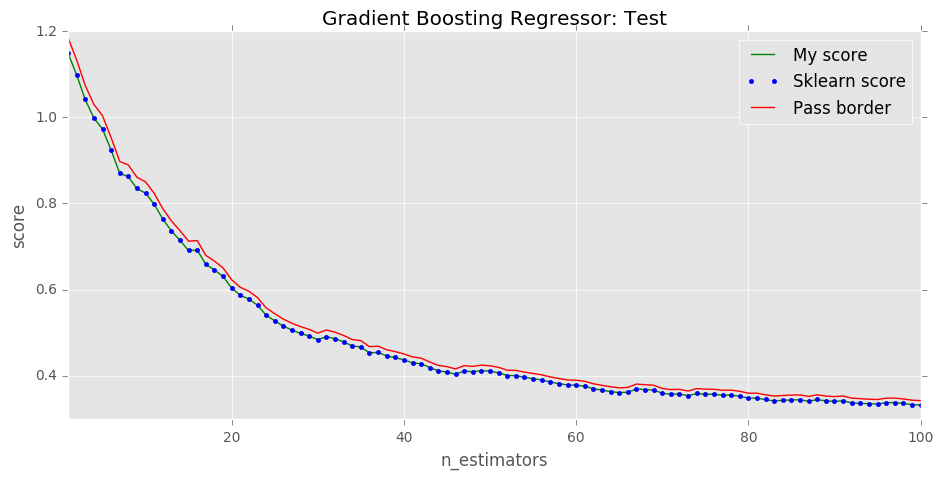

In [52]:
compare_plot('Test',
             model.test_losses,
             [LogisticLoss()(y_test, y_pred) for y_pred in model_sk.staged_decision_function(X_test)],
             range(1, len(model.test_losses)+1))

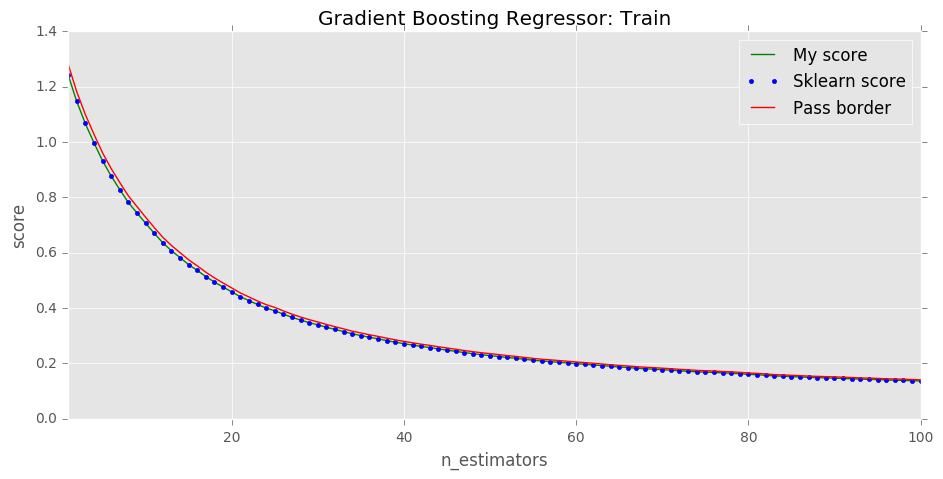

In [53]:
compare_plot('Train',
             model.train_losses,
             [LogisticLoss()(y_train, y_pred) for y_pred in model_sk.staged_decision_function(X_train)],
             range(1, len(model.train_losses)+1))

# More trees on wine

In [132]:
X_train, X_test, y_train, y_test = loadWine(10)

### Graphics 100

In [133]:
model = GradientBoostingClassifier(max_depth=3, n_estimators=100, learning_rate=0.1, random_state=41, verbose=True)

In [134]:
model.fit(X_train, y_train, X_test, y_test)

Step:	0, Train Loss: 97.584554, Train Acc: 1.000000, Test Loss: 51.925500, Test Acc: 0.830508
Step:	1, Train Loss: 75.191578, Train Acc: 1.000000, Test Loss: 43.455278, Test Acc: 0.830508
Step:	2, Train Loss: 58.912583, Train Acc: 1.000000, Test Loss: 37.377028, Test Acc: 0.830508
Step:	3, Train Loss: 46.662814, Train Acc: 1.000000, Test Loss: 32.865998, Test Acc: 0.830508
Step:	4, Train Loss: 37.242336, Train Acc: 1.000000, Test Loss: 29.450578, Test Acc: 0.830508
Step:	5, Train Loss: 29.889291, Train Acc: 1.000000, Test Loss: 26.833016, Test Acc: 0.830508
Step:	6, Train Loss: 24.088425, Train Acc: 1.000000, Test Loss: 24.812889, Test Acc: 0.830508
Step:	7, Train Loss: 19.475700, Train Acc: 1.000000, Test Loss: 23.249134, Test Acc: 0.830508
Step:	8, Train Loss: 15.785611, Train Acc: 1.000000, Test Loss: 22.039195, Test Acc: 0.830508
Step:	9, Train Loss: 12.819841, Train Acc: 1.000000, Test Loss: 21.106664, Test Acc: 0.830508
Step:	10, Train Loss: 10.427513, Train Acc: 1.000000, Test L

In [135]:
model_sk = GBC(n_estimators=100, max_depth=3, criterion='mse', loss='deviance',
               random_state=41)

In [136]:
model_sk.fit(X_train, y_train)

GradientBoostingClassifier(criterion='mse', init=None, learning_rate=0.1,
              loss='deviance', max_depth=3, max_features=None,
              max_leaf_nodes=None, min_impurity_split=1e-07,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=41, subsample=1.0, verbose=0,
              warm_start=False)

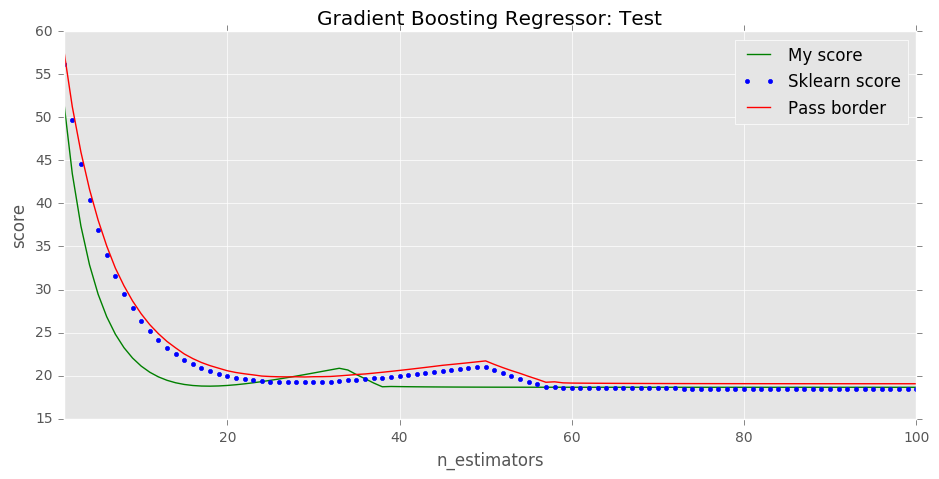

In [139]:
compare_plot('Test',
             model.test_losses,
             [MultiLogisticLoss(3)(y_test, y_pred) for y_pred in model_sk.staged_decision_function(X_test)],
             range(1, len(model.test_losses)+1))

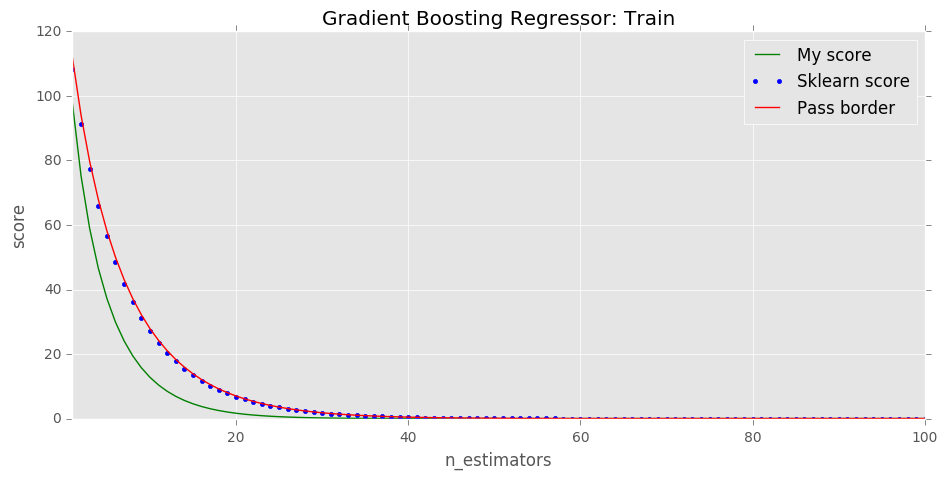

In [140]:
compare_plot('Train',
             model.train_losses,
             [MultiLogisticLoss(3)(y_train, y_pred) for y_pred in model_sk.staged_decision_function(X_train)],
             range(1, len(model.train_losses)+1))

## OneVsRest

In [86]:
X_train, X_test, y_train, y_test = loadWine(30)

In [107]:
class MultiGradientBoostingClassifier:
    def __init__(self, max_depth = 3, n_estimators=5, random_state=None, learning_rate = 0.1, verbose = False):
        self.max_depth = max_depth
        self.n_estimators = n_estimators
        self.random_state = random_state
        self.learning_rate = learning_rate
        self.verbose = verbose
        
    def fit(self, X, y, X_test = None, y_test = None):
        self.train_losses = []
        self.test_losses = []
        X = X.astype(np.float32)
        #n_samples, self.n_features = X.shape
        self.n_classes = len(np.unique(y_train))
        if self.n_classes < 3:
            raise BaseException('You must have more than 2 classes')
         
        self.models = []
        for i in xrange(self.n_classes):
            print 'Model {}:'.format(i)
            self.models.append(GradientBoostingClassifier(self.max_depth, self.n_estimators,
                                                     self.random_state, self.learning_rate, self.verbose))
            if not ((X_test is None) or (y_test is None)):
                self.models[i].fit(X, np.array(y == i, dtype=np.int32),
                                    X_test, np.array(y_test == i, dtype=np.int32))
            else:
                self.models[i].fit(X, np.array(y == i, dtype=np.float32))
        self.train_losses = np.mean([self.models[i].train_losses for i in xrange(self.n_classes)], axis=0)
        if not ((X_test is None) or (y_test is None)):
            self.test_losses = np.mean([self.models[i].test_losses for i in xrange(self.n_classes)], axis=0)
        
    def predict_proba(self, X):
        return np.array([m.predict_proba(X) for m in self.models]).T
        

In [137]:
n_estimators = 100

In [138]:
mclf = MultiGradientBoostingClassifier(max_depth=2, n_estimators=n_estimators, verbose=True)

In [139]:
#mclf.fit(X_train, y_train, X_test, y_test)

Model 0:
Step:	0, Train Loss: 1.124616, Train Acc: 0.655462, Test Loss: 1.101514, Test Acc: 0.694915
Step:	1, Train Loss: 0.992782, Train Acc: 0.655462, Test Loss: 1.002913, Test Acc: 0.694915
Step:	2, Train Loss: 0.877051, Train Acc: 0.941176, Test Loss: 0.889863, Test Acc: 0.898305
Step:	3, Train Loss: 0.780451, Train Acc: 0.957983, Test Loss: 0.805152, Test Acc: 0.898305
Step:	4, Train Loss: 0.698482, Train Acc: 0.957983, Test Loss: 0.723869, Test Acc: 0.898305
Step:	5, Train Loss: 0.628867, Train Acc: 0.983193, Test Loss: 0.655802, Test Acc: 0.932203
Step:	6, Train Loss: 0.568228, Train Acc: 0.983193, Test Loss: 0.595833, Test Acc: 0.966102
Step:	7, Train Loss: 0.515386, Train Acc: 0.983193, Test Loss: 0.551314, Test Acc: 0.983051
Step:	8, Train Loss: 0.469448, Train Acc: 0.983193, Test Loss: 0.505940, Test Acc: 0.983051
Step:	9, Train Loss: 0.428975, Train Acc: 0.983193, Test Loss: 0.466592, Test Acc: 0.983051
Step:	10, Train Loss: 0.392706, Train Acc: 0.983193, Test Loss: 0.43697

In [140]:
accuracy_score(mclf.predict_proba(X_test)[0].argmax(axis=1),  y_test)

0.96610169491525422

In [141]:
sk_mclf = GBC(max_depth=2, n_estimators=n_estimators, criterion='mse', verbose=True)
sk_mclf.fit(X_train, y_train)

      Iter       Train Loss   Remaining Time 
         1         111.1791            0.38s
         2          95.9170            0.30s
         3          82.8190            0.25s
         4          72.0507            0.23s
         5          62.9393            0.22s
         6          54.6487            0.21s
         7          47.6413            0.21s
         8          41.6594            0.20s
         9          36.5688            0.19s
        10          32.2059            0.19s
        20           9.8267            0.15s
        30           3.2029            0.14s
        40           1.0835            0.12s
        50           0.4238            0.10s
        60           0.1675            0.08s
        70           0.0684            0.06s
        80           0.0346            0.04s
        90           0.0275            0.02s
       100           0.0256            0.00s


GradientBoostingClassifier(criterion='mse', init=None, learning_rate=0.1,
              loss='deviance', max_depth=2, max_features=None,
              max_leaf_nodes=None, min_impurity_split=1e-07,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0,
              verbose=True, warm_start=False)

In [142]:
accuracy_score(sk_mclf.predict(X_test), y_test)

0.96610169491525422

In [143]:
sk_train_losses = []
for y_pred in sk_mclf.staged_decision_function(X_train):
    sk_train_losses.append([])
    for i in xrange(sk_mclf.n_classes_):
        sk_train_losses[-1].append(LogisticLoss()(np.array(y_train == i, dtype=np.int32), y_pred[:, i]))
sk_train_losses = np.mean(sk_train_losses, axis=1)

In [144]:
sk_test_losses = []
for y_pred in sk_mclf.staged_decision_function(X_test):
    sk_test_losses.append([])
    for i in xrange(sk_mclf.n_classes_):
        sk_test_losses[-1].append(LogisticLoss()(np.array(y_test == i, dtype=np.int32), y_pred[:, i]))
sk_test_losses = np.mean(sk_test_losses, axis=1)

# MULTINOMIAL ONE VS REST BAD EXAMPLE

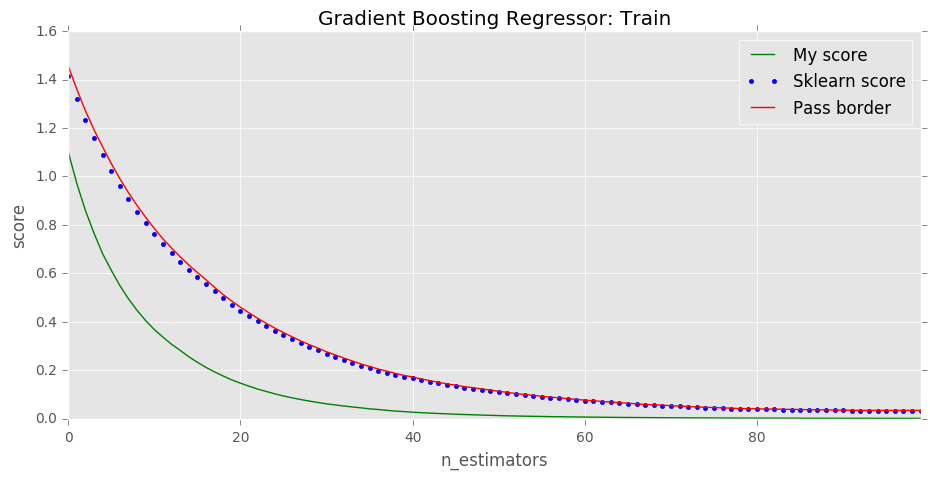

In [147]:
compare_plot('Train', mclf.train_losses, sk_train_losses, range(n_estimators))

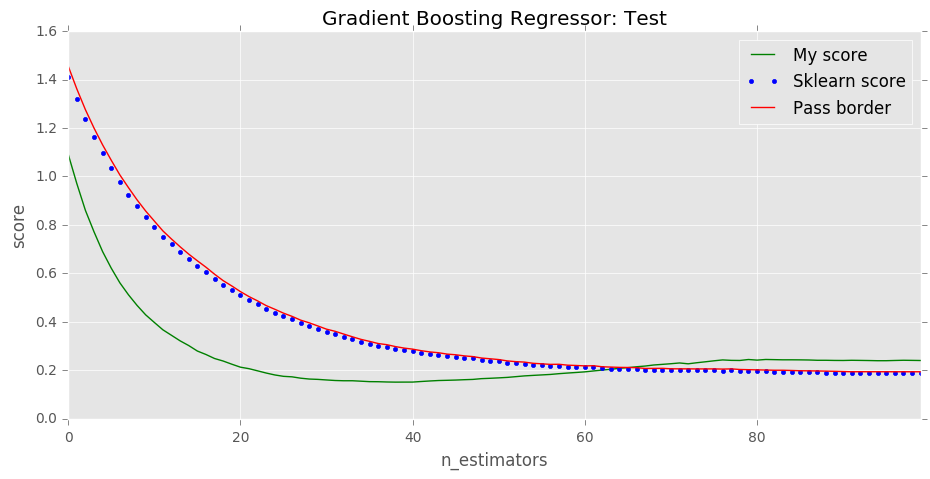

In [148]:
compare_plot('Test', mclf.test_losses, sk_test_losses, range(n_estimators))

## Multinomial

## Weighted voting

In [83]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression

In [82]:
from sklearn.neighbors import KNeighborsClassifier

In [104]:
clf = VotingClassifier(voting='soft', estimators=[('knn', KNeighborsClassifier()),
                                   ('gbc', GBC(criterion='mse', n_estimators=10, random_state=41)),
                                   ('lr', LogisticRegression())], n_jobs=-1)

In [105]:
clf.fit(X_train, y_train)

VotingClassifier(estimators=[('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')), ('gbc', GradientBoostingClassifier(criterion='mse', init=None, learning_rate=0.1,
              loss='deviance', m...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))],
         n_jobs=-1, voting='soft', weights=None)

In [106]:
accuracy_score(y_test, clf.predict(X_test))

0.95147175815433571